Shape of images: (70000, 784)
Shape of labels: (70000,)


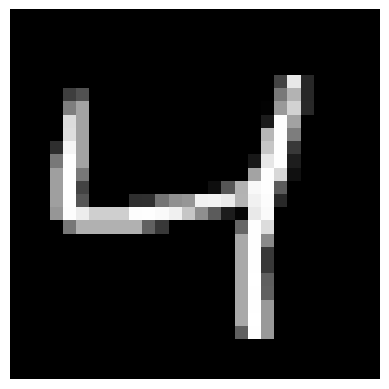

Label of the image: 4


In [11]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Load MNIST dataset
mnist = fetch_openml('mnist_784')
images = mnist['data']
labels = mnist['target']

# Print the shape of the dataset
print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)

# Plot the first image
first_image = images.iloc[2].values.reshape(28, 28)
plt.imshow(first_image, cmap='gray')
plt.axis('off')
plt.show()

# Print the label of the first image
print("Label of the image:", labels[2])


In [2]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784')
images = mnist['data']
labels = mnist['target']

# Scale pixel values to the range [0, 1]
scaler = MinMaxScaler()
images_normalized = scaler.fit_transform(images)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images_normalized, labels, test_size=0.4, random_state=42)

# Train the SVM model
svm_classifier = SVC(kernel='rbf', C=10, gamma='scale')
svm_classifier.fit(X_train, y_train)

# Evaluate the model
accuracy = svm_classifier.score(X_test, y_test)
print("Accuracy of SVM classifier:", accuracy)


Accuracy of SVM classifier: 0.9811071428571428


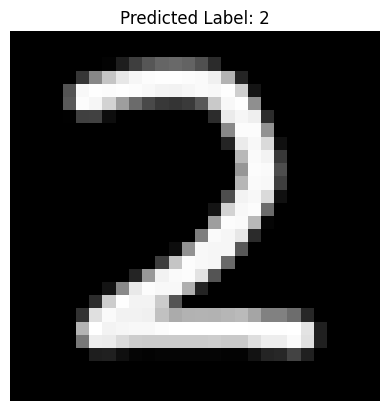

In [68]:
# convert an image I drew to test the model with
from PIL import Image, ImageOps
import numpy as np

# Load your handwritten image
image = Image.open("image.png").convert("L")  # Convert to grayscale

# Resize the image to 28x28 pixels
image = image.resize((28, 28))

# Invert the pixel values (if necessary)
image = ImageOps.invert(image)

# Convert the image to a numpy array
image_array = np.array(image)

# Flatten the image array
image_flattened = image_array.flatten()

# Scale the pixel values to the range [0, 1]
image_scaled = image_flattened / 255.0

# Predict the label using the trained SVM model
predicted_label = svm_classifier.predict([image_scaled])[0]

image_to_show = image_scaled.reshape(28, 28)

# Display the image along with the true and predicted labels
plt.imshow(image_to_show, cmap='gray')
plt.axis('off')
plt.title(f'Predicted Label: {predicted_label}')
plt.show()


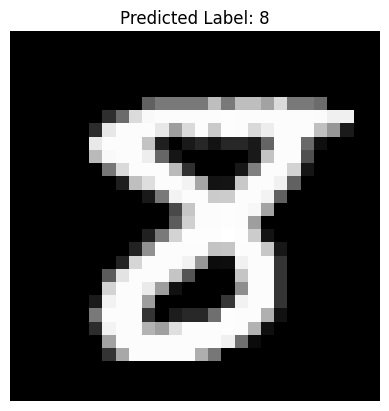

In [62]:
# Plot a random number from the testing set

# Extract the image and corresponding label at the random index
new_image = X_test[0]

# Use the trained SVM model to predict the label for the selected image
predicted_label = svm_classifier.predict([new_image])[0]

# Reshape the image to its original shape (28x28)
random_image_reshaped = new_image.reshape(28, 28)

# Display the image along with the true and predicted labels
plt.imshow(random_image_reshaped, cmap='gray')
plt.axis('off')
plt.title(f'Predicted Label: {predicted_label}')
plt.show()
